# Mid Term 1 - KNN & Logistic Regression
*Authors*:  Aliotta Lorenzo, Prataiolo Loris


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator
import time

In [39]:
ds1 = np.load("synthetic_linear_gaussian/linsep_d2_n200.npz")     # (d = 2 ;  n = 200)
ds2 = np.load("synthetic_linear_gaussian/linsep_d10_n1000.npz")   # (d = 10;  n = 1000)
ds3 = np.load("synthetic_linear_gaussian/linsep_d500_n50000.npz") # (d = 500; n = 50000)

In [40]:
print(ds1.files)

['X_train', 'y_train', 'X_test', 'y_test', 'flip_mask', 'noise_rate', 'seed', 'feature_dim', 'n_samples', 'test_size']


# KNN

In [41]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [42]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [43]:
def allDistances(X1, X2):
    '''
    Compute pairwise Euclidean distnaces between two X sets.
    output: D :=  A matrix (X1_rows x X2_rows) where D[i, j] equals the Euclidean distance 
                  between the i-th sample in X1 and the j-th sample in X2.
    '''
    D = np.zeros((X1.shape[0], X2.shape[0]))

    for i in range(X1.shape[0]):
        for j in range (X2.shape[0]):
            D[i,j] = euclidDistance(X1[i,:], X2[j,:])
            
    return D

In [44]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0]  # number of the training inputs
    n_test  = Xte.shape[0]  # number of the test inputs

    # sanity checks
    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xte,Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):

        # Take all distances for the current test point and sort them 
        idx_dist = dist[idx, :]     
        idx_sort = np.argsort(idx_dist)
        
        # Get the indices of the k lowest of distances
        k_dist_index = idx_sort[:k]
        
        # Compute the mean of the output values of the corresponding training points and taking the sign of it.
        mean = np.mean(Ytr[k_dist_index])

        Ypred[idx] = np.sign(mean) # returns -1 if x < 0, 0 if x==0, 1 if x > 0
    return Ypred

In [45]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list, rng: int | Generator | None = None):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try
     - rng : Optional[int | Generator | None]
         optional random state

    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    #rng = _check_random_generator(rng)
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds)) # train
    val_errors = np.zeros((num_k, num_folds)) # validation

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rng.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds) 
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        
        # Split training set in training part and validation part
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]

        x_val   = Xtr[val_mask==True]
        y_val   = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(k_list):
            # Compute the training error of the kNN classifier for the given value of k
            Tpred = kNNClassify(x_train, y_train, current_k, x_train)
            tr_errors[k_idx, fold_idx] = calcError(Tpred, y_train)
            
            # Compute the validation error of the kNN classifier for the given value of k
            Vpred = kNNClassify(x_train, y_train, current_k, x_val)
            val_errors[k_idx, fold_idx] = calcError(Vpred, y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)

    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.where(k_list == best_k)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [54]:
def plot_training_validation_error_mean (k_list, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds):
    # We plot the training e validation error
    fig, ax = plt.subplots()
    ax.plot(k_list, val_err_mean, label="Validation")
    ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
    ax.plot(k_list, tr_err_mean, label="Training")
    ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)
    
    ax.set_title(f"{num_folds}-Fold CV")
    ax.set_ylabel("Error")
    ax.set_xlabel("k Vlaues")
    ax.legend();

In [79]:
def perform_knn_process(dataset):

    Xtr = dataset['X_train']
    Xte = dataset['X_test']
    Ytr = dataset['y_train']
    Yte = dataset['y_test']

    k_values = np.arange(1,21,2)
    rng = np.random.default_rng(45)
    num_folds = 5 if dataset['n_samples'] <= 1000 else 10

    best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, num_folds=num_folds, k_list=k_values, rng=rng)

    plot_training_validation_error_mean(k_values, val_err_mean, val_err_std, tr_err_mean, tr_err_std, num_folds)
    
    # evaluate the error for training set and test set using the best k
    # and estimate the performing time of KNN Classifier
    
    tr_start = time.perf_counter()
    tr_pred = kNNClassify(Xtr, Ytr, best_k, Xtr)
    tr_end   = time.perf_counter()
    
    te_start = time.perf_counter()
    te_pred = kNNClassify(Xte, Yte, best_k, Xte)
    te_end   = time.perf_counter()

    tr_error = calcError(tr_pred, Ytr)
    te_error = calcError(te_pred, Yte)

    print(f"The training error with the best k ({best_k}) is: {tr_error*100:.3f}% with performing time: {tr_end-tr_start:.8f} seconds")
    print(f"The test error with the best k ({best_k}) is: {te_error*100:.3f}% with performing time: {te_end-te_start:.8f} seconds")

The training error with the best k (17) is: 12.667% with performing time: 0.07629460 seconds
The test error with the best k (17) is: 14.000% with performing time: 0.00899716 seconds


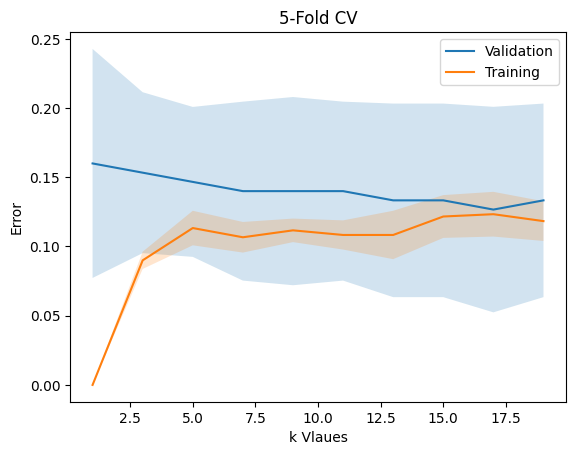

In [81]:
perform_knn_process(ds1)

The training error with the best k (19) is: 18.133% with performing time: 1.97364231 seconds
The test error with the best k (19) is: 24.000% with performing time: 0.22250275 seconds


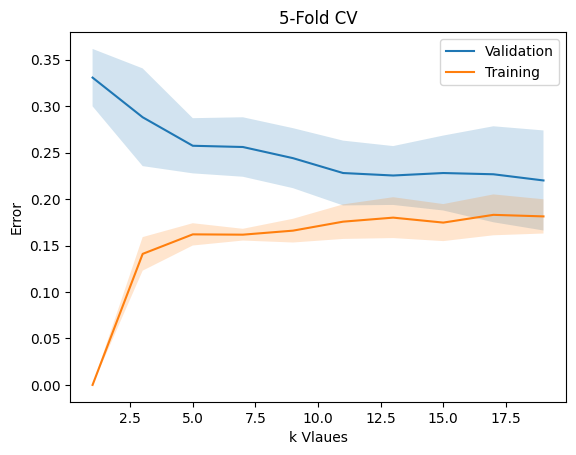

In [82]:
perform_knn_process(ds2)

In [ ]:
perform_knn_process(ds3)

# Logistic Regression